#### OBJETIVO: Modelos Predictivos de PM2.5 simples

In [19]:
#Librerias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from pygam import LinearGAM, s, f
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, gaussian_kde
import statsmodels.formula.api as smf


print("librerias ok")

librerias ok


In [21]:
### -------------- REGRESION LINEAL SIMPLE --------------------------
def evaluar_modelo(modelo, 
                   X_test, 
                   y_test=None, 
                   df_test=None,
                   variable_real="PM25",
                   tipo_modelo="LM"):
    """
    Evalúa el desempeño de un modelo predictivo.
    
    Parameters
    ----------
    modelo : modelo entrenado (sklearn o xgboost)
    X_test : DataFrame o array con variables predictoras
    y_test : array con valores reales (solo para XGB)
    df_test : DataFrame con variable_real (para LM, RF, etc.)
    variable_real : str, nombre de la variable objetivo
    tipo_modelo : str, 'LM', 'RF', 'XGB', etc.
    """

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Valores reales
    if tipo_modelo == "XGB":
        y_true = np.array(y_test)
    else:
        y_true = np.array(df_test[variable_real])

    # Armar DataFrame
    df = pd.DataFrame({
        "predicciones": y_pred,
        "valores_reales": y_true
    })

    # Filtrar predicciones negativas
    df = df[df["predicciones"] > 0]

    # Metricas
    r2 = np.corrcoef(df["predicciones"], df["valores_reales"])[0, 1] ** 2
    pearson = pearsonr(df["valores_reales"], df["predicciones"])[0]
    rmse = np.sqrt(mean_squared_error(df["valores_reales"], df["predicciones"]))
    bias = np.mean(df["predicciones"] - df["valores_reales"])

    resultados = pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["predicciones"].min(), 3)],
        "Max_Pred": [round(df["predicciones"].max(), 3)]
    })

    return resultados


##################################################################
### -------------- REGRESION LINEAL MULTIPLE --------------------------

def evaluar_modelo_rlm(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "real": y_test
    })

    df = df[df["pred"] > 0]

    r2 = r2_score(df["real"], df["pred"])
    pearson = df["real"].corr(df["pred"])
    rmse = np.sqrt(mean_squared_error(df["real"], df["pred"]))
    bias = (df["pred"] - df["real"]).mean()

    resultados = pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["pred"].min(), 3)],
        "Max_Pred": [round(df["pred"].max(), 3)]
    })

    return resultados, df



###################################################################
### ------- Modelos RIDGE ------------------
def evaluar_modelo_ridge(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "PM25": y_test
    })

    df = df[df["pred"] > 0]

    r2 = np.corrcoef(df["pred"], df["PM25"])[0, 1] ** 2
    pearson = np.corrcoef(df["PM25"], df["pred"])[0, 1]
    rmse = np.sqrt(mean_squared_error(df["PM25"], df["pred"]))
    bias = np.mean(df["pred"] - df["PM25"])
    return pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["pred"].min(), 3)],
        "Max_Pred": [round(df["pred"].max(), 3)]
    })


###################################################################
### ------- Modelos LASSO ------------------

def evaluar_lasso(model, X_test, y_test):
    pred = model.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "y": y_test
    })

    df = df[df["pred"] > 0]

    r2 = r2_score(df["y"], df["pred"])
    pearson = pearsonr(df["y"], df["pred"])[0]
    rmse = np.sqrt(mean_squared_error(df["y"], df["pred"]))
    bias = np.mean(df["pred"] - df["y"])
    
    #Generar dataframe como salida
    return pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["pred"].min(), 3)],
        "Max_Pred": [round(df["pred"].max(), 3)]
    })

###################################################################
### ------- Modelos Aditivos Generalizados (GAM) ------------------
def evaluar_modelo_gam(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({"pred": pred, "PM25": y_test})
    df = df[df["pred"] > 0]

    r2 = np.corrcoef(df["pred"], df["PM25"])[0, 1] ** 2
    pearson = pearsonr(df["PM25"], df["pred"])[0]
    rmse = np.sqrt(mean_squared_error(df["PM25"], df["pred"]))
    bias = np.mean(df["pred"] - df["PM25"])

    resultados = pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["pred"].min(), 3)],
        "Max_Pred": [round(df["pred"].max(), 3)]
    })
    return resultados, df


###################################################################
### ------- Modelos Aditivos Generalizados (GAM) ------------------

def evaluar_modelo_lm(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "real": y_test
    })

    df = df[df["pred"] > 0]

    r2 = r2_score(df["real"], df["pred"])
    pearson = df["real"].corr(df["pred"])
    rmse = np.sqrt(mean_squared_error(df["real"], df["pred"]))
    bias = (df["pred"] - df["real"]).mean()

    return {
        "R2": round(r2, 5),
        "Pearson": round(pearson, 3),
        "RMSE": round(rmse, 3),
        "Bias": round(bias, 3),
        "Min_Pred": round(df["pred"].min(), 3),
        "Max_Pred": round(df["pred"].max(), 3)
    }


########################################################################
### ------ Modelo predictivo Modelo Lineal Generalizado (GLM) ---------
def evaluar_modelo_glm(y_true, y_pred):
    mask = (~np.isnan(y_pred)) & (y_pred > 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2 = np.corrcoef(y_true, y_pred)[0,1]**2
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)

    return {
        "R2": round(r2, 3),
        "RMSE": round(rmse, 3),
        "Bias": round(bias, 3),
        "Min": round(y_pred.min(), 2),
        "Max": round(y_pred.max(), 2)
    }

MX
        R2  Pearson   RMSE   Bias  Min_Pred  Max_Pred
0  0.16922    0.411  9.068  0.033     15.58    47.867


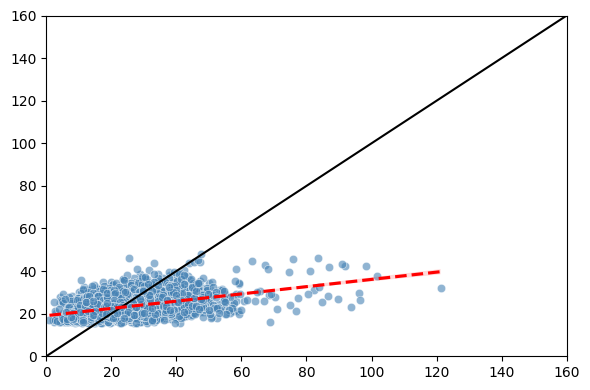

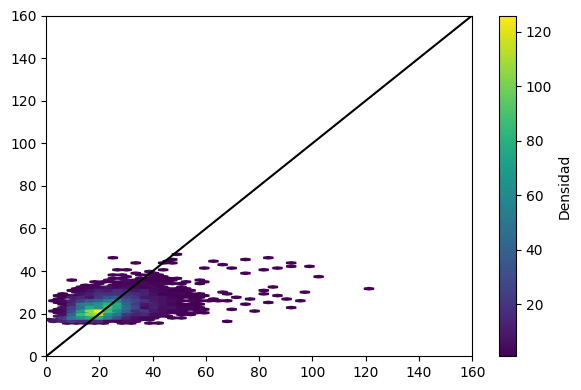

In [ ]:
### -------------- REGRESION LINEAL SIMPLE --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "MX"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Setear las variables del modelo
X_train = train_data[["AOD_055"]]
y_train = train_data["PM25"]
X_test = test_data[["AOD_055"]]

# Generar modelo predictivo: Regresion lineal simple
modelo_lm = LinearRegression()
modelo_lm.fit(X_train, y_train)

resultados_lm = evaluar_modelo(modelo=modelo_lm,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)
print(estacion)
print(resultados_lm)
#######################################
#Hacer plot con las predicciones realizadas a partir del modelo entrenamo con el dataset de entrenamiento
test_data["pred"] = modelo_lm.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Linea 1:1
plt.plot([0,160], [0,160], color="black")

# Regresion
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.tight_layout()
plt.show()
#####################################################
### Otro plot, de densidad

plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


      R2  Pearson   RMSE   Bias  Min_Pred  Max_Pred
0  0.106    0.326  9.412  0.073    17.445    44.119


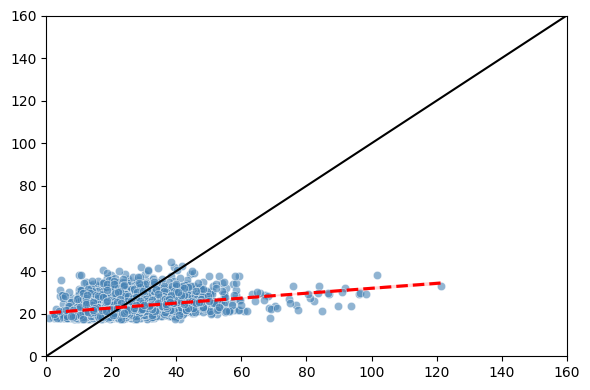

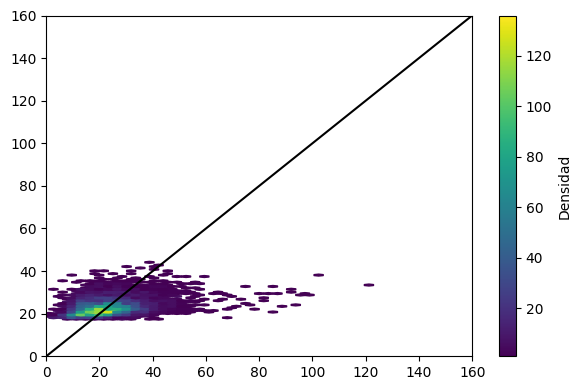

In [ ]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR BLH --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "MX"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Generacion de variables ==> correccion del AOD por blh
train_data["AOD_055_correct"] = train_data["AOD_055"] / train_data["blh_mean"]
test_data["AOD_055_correct"]  = test_data["AOD_055"]  / test_data["blh_mean"]


#Setear las variables para el modelo
X_train = train_data[["AOD_055_correct"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_055_correct"]]
#Generar mnodelo
modelo_lm_corr = LinearRegression()
modelo_lm_corr.fit(X_train, y_train)

resultados_lm_corr = evaluar_modelo(
    modelo=modelo_lm_corr,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)

print(resultados_lm_corr)

#############################################
# Plot:
test_data["pred"] = modelo_lm_corr.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

###############
#Otro plot similar
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.04575    0.214  15.643  0.111    18.832   110.409


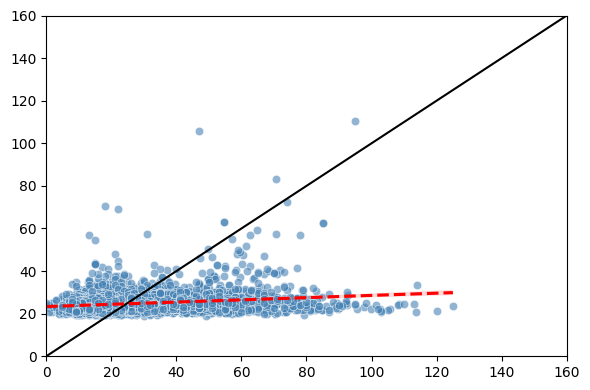

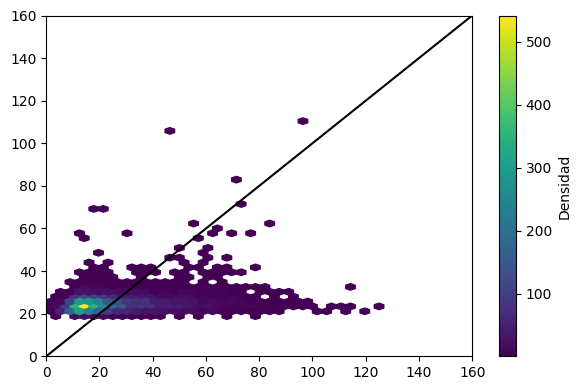

In [7]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR HUMEDAD --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "RH"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Correccion por humedad
train_data["funcRH"] = 1 / (1 - (train_data["RH"] / 100))
test_data["funcRH"]  = 1 / (1 - (test_data["RH"]  / 100))

train_data["AOD_055_correct"] = train_data["AOD_055"] / train_data["funcRH"]
test_data["AOD_055_correct"]  = test_data["AOD_055"]  / test_data["funcRH"]

#Setear variables importantes
X_train = train_data[["AOD_055_correct"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_055_correct"]]

#Ajustar el modelo
modelo_lm_rh = LinearRegression()
modelo_lm_rh.fit(X_train, y_train)

#Evaluar el modelo
resultados_lm_rh = evaluar_modelo(
    modelo=modelo_lm_rh,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)

print(estacion)
print(resultados_lm_rh)

#########################################################
#Plot
test_data["pred"] = modelo_lm_rh.predict(X_test)


plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

########################################
#Otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()



CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.31598    0.562  13.239  0.068    17.563   158.183


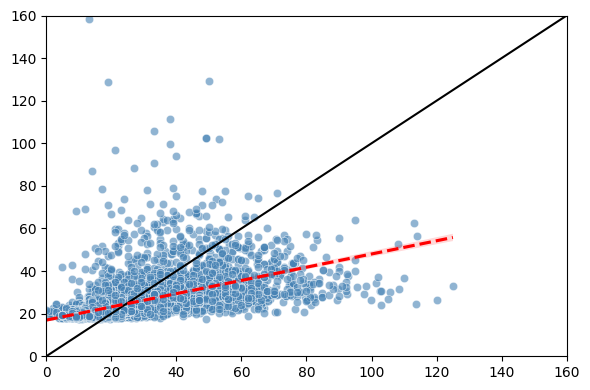

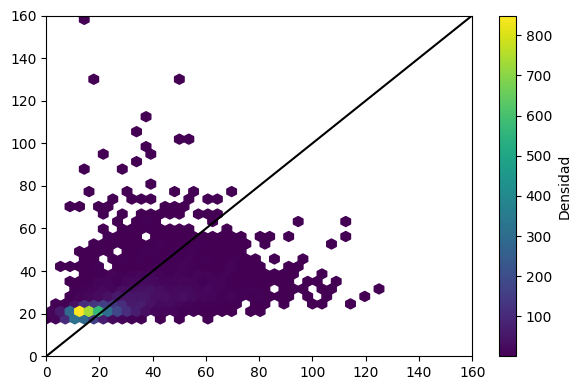

In [9]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR AMBAS CORRECCIONES AL AOD --------------------------
# Dataset de entrada de entrenamiento y testeo


estacion = "CH"
modelo_id = "RH"   # mismo identificador que en R

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Generar variables con ambas correcciones al AOD
train_data["AOD_corrected"] = (
    train_data["AOD_055"] * (1 - train_data["RH"] / 100)
) / train_data["blh_mean"]

test_data["AOD_corrected"] = (
    test_data["AOD_055"] * (1 - test_data["RH"] / 100)
) / test_data["blh_mean"]

# Se setean las variables de importancia
X_train = train_data[["AOD_corrected"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_corrected"]]

# Ajsutar el modelo
modelo_lm_blhrh = LinearRegression()
modelo_lm_blhrh.fit(X_train, y_train)

#Evaluar el modelo
resultados_lm_blhrh = evaluar_modelo(
    modelo=modelo_lm_blhrh,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)
#Resultados
print(estacion)
print(resultados_lm_blhrh)
###########################################################
#Plot

test_data["pred"] = modelo_lm_blhrh.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#3## otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()








CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.56687    0.753  10.841  0.106     0.022    95.293


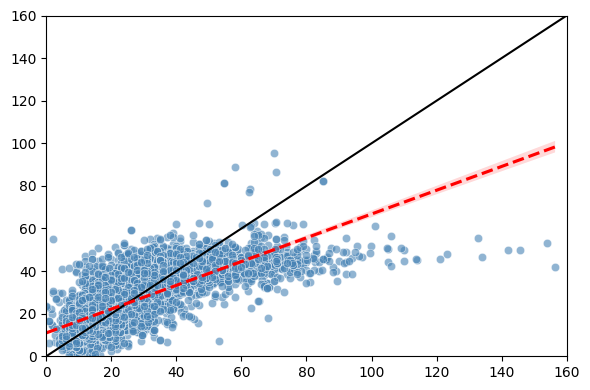

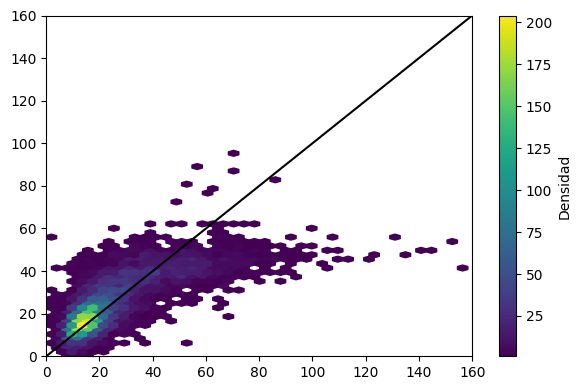

In [14]:
### -------------- REGRESION LINEAL MULTIPLE --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Revisar para cada sitio las variables finales
features = [
    "AOD_055",
    "ndvi",
    "BCSMASS_dia",
    "DUSMASS_dia",
    "SO2SMASS_dia",
    "SO4SMASS_dia",
    "SSSMASS_dia",
    "blh_mean",
    "t2m_mean",
    "DEM",
    "d2m_mean",
    "v10_mean",
    "u10_mean",
    "tp_mean",
    "dayWeek"
]

#Setear variables para ajustar el modelo
X_train = train_data[features]
y_train = train_data["PM25"]

X_test = test_data[features]
y_test = test_data["PM25"]

#Ajustar modelo
modelo_rlm = LinearRegression()
modelo_rlm.fit(X_train, y_train)

#Evaluar el desempeño con funcion
resultados_rlm, df_plot = evaluar_modelo_rlm(modelo_rlm, X_test, y_test)

print(estacion)
print(resultados_rlm)

############################################################
#Plot
plt.figure(figsize=(6,4))

sns.scatterplot(
    x=df_plot["real"],
    y=df_plot["pred"],
    color="steelblue",
    alpha=0.6
)

# Linea 1:1
plt.plot([0,160], [0,160], color="black")

# Linea de regresión
sns.regplot(
    x=df_plot["real"],
    y=df_plot["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#########################
#Otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    df_plot["real"],
    df_plot["pred"],
    gridsize=40,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


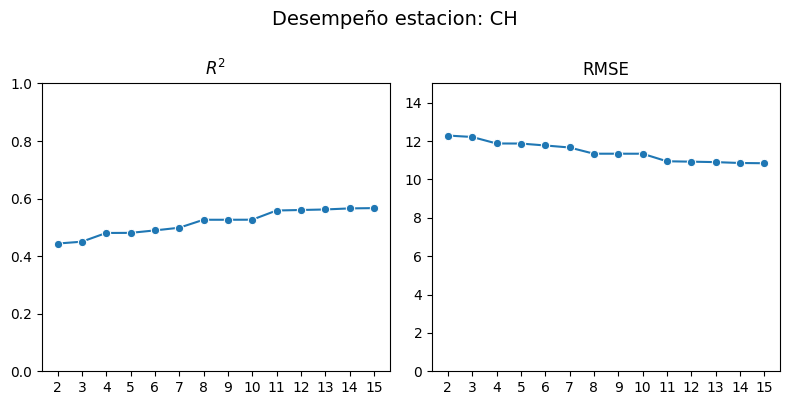

In [ ]:
### -------------- REGRESION LINEAL MULTIPLE --------------------------
# Pero se agregan progresivamente las variables
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Variables hay que considerar las particularidaes de cada centro urbano
variables = [
    "blh_mean", "d2m_mean", "t2m_mean", "v10_mean", "u10_mean", "tp_mean",
    "ndvi", "BCSMASS_dia", "DUSMASS_dia", "SO2SMASS_dia", "SO4SMASS_dia",
    "SSSMASS_dia", "DEM", "dayWeek"
]


###


# Iteramos entre las variables para evaluar el desempeño
resultados_modelos = []

for i, var in enumerate(variables, start=1):
    vars_actuales = ["AOD_055"] + variables[:i]

    X_train = train_data[vars_actuales]
    X_test  = test_data[vars_actuales]

    modelo_lm = LinearRegression()
    modelo_lm.fit(X_train, y_train)

    res = evaluar_modelo_lm(modelo_lm, X_test, y_test)
    res["Modelo"] = f"Modelo_{i+1}"
    res["Variables"] = ", ".join(vars_actuales)

    resultados_modelos.append(res)

tabla_resultados = pd.DataFrame(resultados_modelos)
tabla_resultados["Num_Variables"] = tabla_resultados["Variables"].apply(
    lambda x: len(x.split(", "))
)
#Resultados en formato df
tabla_resultados = pd.DataFrame(resultados_modelos)
tabla_resultados["Num_Variables"] = tabla_resultados["Variables"].apply(
    lambda x: len(x.split(", "))
)

#Unimos todo columas/filas
data_melt = tabla_resultados.melt(
    id_vars="Num_Variables",
    value_vars=["R2", "RMSE"],
    var_name="Metrica",
    value_name="Valor"
)

#############################################################################
#Plot con ambas metricas

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
fig.suptitle(
    f"Desempeño estacion: {estacion}",
    fontsize=14,
    y=1.0
)
# R2
sns.lineplot(
    data=data_melt[data_melt["Metrica"] == "R2"],
    x="Num_Variables",
    y="Valor",
    marker="o",
    ax=axes[0]
)
axes[0].set_ylim(0, 1)
axes[0].set_title(r"$R^2$")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# RMSE
sns.lineplot(
    data=data_melt[data_melt["Metrica"] == "RMSE"],
    x="Num_Variables",
    y="Valor",
    marker="o",
    ax=axes[1]
)
axes[1].set_ylim(0, 15)
axes[1].set_title("RMSE")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# 👉 Forzar ticks de 1 en 1
x_ticks = range(
    int(tabla_resultados["Num_Variables"].min()),
    int(tabla_resultados["Num_Variables"].max()) + 1
)

for ax in axes:
    ax.set_xticks(x_ticks)

plt.tight_layout()
plt.show()



d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Mejor alpha (lambda): 0.08447926727224629
CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.56738    0.753  10.834  0.091      0.11    134.31
        variable  coeficiente  abs_coef
11      u10_mean    -5.186448  5.186448
7       blh_mean    -4.442784  4.442784
4   SO2SMASS_dia     3.498784  3.498784
10      t2m_mean     3.041761  3.041761
0        AOD_055     2.539438  2.539438
8       d2m_mean    -2.481280  2.481280
1           ndvi    -1.615089  1.615089
2    BCSMASS_dia     1.606106  1.606106
12       tp_mean    -1.437114  1.437114
13           DEM    -1.307805  1.307805
6    SSSMASS_dia     0.645634  0.645634
5   SO4SMASS_dia    -0.491661  0.491661
9       v10_mean    -0.409468  0.409468
14       dayWeek     0.397157  0.397157
3    DUSMASS_dia     0.273107  0.273107


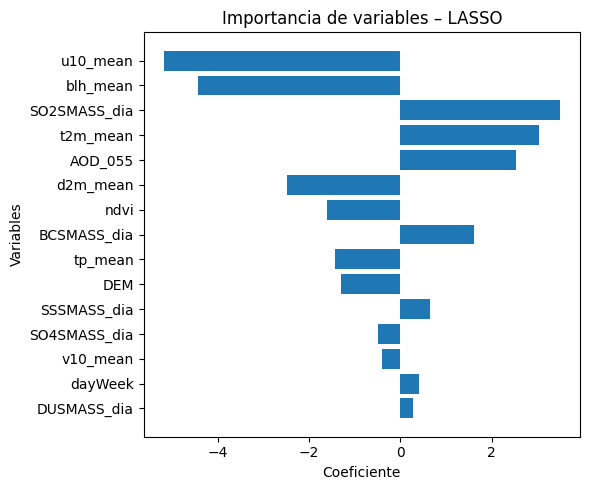

d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


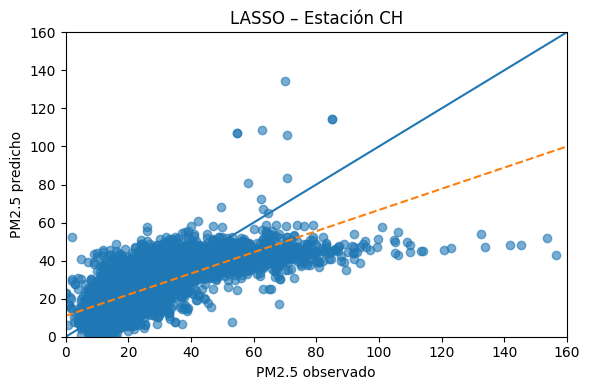

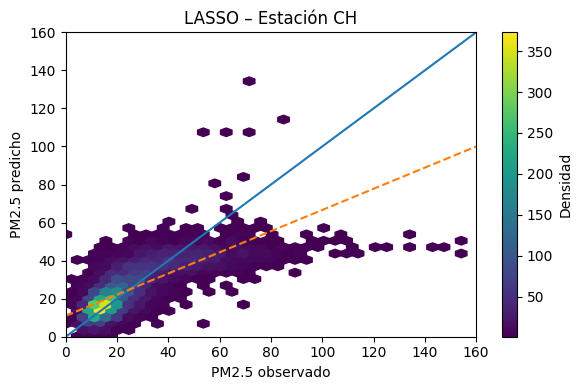

In [ ]:
### -------------- MODELO LASSO  --------------------------

# Dataset de entrada de entrenamiento y testeo
estacion = "CH"
modelo = "1"
base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/"

train_data = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_test_{estacion}.csv")

# Variables verificar para cada centro urbnano
variables = [
    "AOD_055", "ndvi", "BCSMASS_dia", "DUSMASS_dia",
    "SO2SMASS_dia", "SO4SMASS_dia", "SSSMASS_dia",
    "blh_mean", "d2m_mean", "v10_mean", "t2m_mean",
    "u10_mean", "tp_mean", "DEM", "dayWeek"
]
#Setear las variables del mdoelo
X_train = train_data[variables]
y_train = train_data["PM25"]

X_test  = test_data[variables]
y_test  = test_data["PM25"]

#Estandarización para las variables, es necesario transformalo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#Hacer la prueba de lasso pero con cross validation. Ver parametros
lasso_cv = LassoCV(
    alphas=None,      # sklearn define el grid automáticamente
    cv=10,
    max_iter=5000,
    random_state=123
)

#Ajsutar modelo con lo sparametros anteriores
lasso_cv.fit(X_train_scaled, y_train)
#
best_alpha = lasso_cv.alpha_
print("Mejor alpha (lambda):", best_alpha)
#Generar otra funcion para evaluar el desempeño


#Resultados
resultados = evaluar_lasso(lasso_cv, X_test_scaled, y_test)
print(estacion)
print(resultados)

#Lasso permite ver la imporancia de las variables, las revisamos
coef_df = pd.DataFrame({
    "variable": variables,
    "coeficiente": lasso_cv.coef_
})

coef_filtrado = coef_df[coef_df["coeficiente"] != 0]
coef_filtrado["abs_coef"] = coef_filtrado["coeficiente"].abs()

coef_filtrado = coef_filtrado.sort_values(
    by="abs_coef", ascending=False
)

print(coef_filtrado)


#########################################
# Plot de la importancia de las variables
plt.figure(figsize=(6, 5))
plt.barh(
    coef_filtrado["variable"],
    coef_filtrado["coeficiente"]
)
plt.xlabel("Coeficiente")
plt.ylabel("Variables")
plt.title("Importancia de variables – LASSO")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#########################################
# Plot 

pred = lasso_cv.predict(X_test_scaled)

df_plot = pd.DataFrame({
    "PM25": y_test,
    "pred": pred
})

# Filtrar predicciones negativas
df_plot = df_plot[df_plot["pred"] > 0]

# Ajustar regresión auxiliar (para la línea roja punteada)
lr_aux = LinearRegression()
lr_aux.fit(df_plot[["PM25"]], df_plot["pred"])

x_line = np.linspace(0, 160, 100).reshape(-1, 1)
y_line = lr_aux.predict(x_line)

plt.figure(figsize=(6, 4))
plt.scatter(df_plot["PM25"], df_plot["pred"], alpha=0.6)

# Línea 1:1
plt.plot([0, 160], [0, 160])

# Línea de regresión
plt.plot(x_line, y_line, linestyle="--")

plt.xlim(0, 160)
plt.ylim(0, 160)

plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"LASSO – Estación {estacion}")

plt.tight_layout()
plt.show()
#############################################################

plt.figure(figsize=(6, 4))

hb = plt.hexbin(
    df_plot["PM25"],
    df_plot["pred"],
    gridsize=35,
    mincnt=1
)

plt.colorbar(hb, label="Densidad")

# Línea 1:1
plt.plot([0, 160], [0, 160])

# Línea de regresión
plt.plot(x_line, y_line, linestyle="--")

plt.xlim(0, 160)
plt.ylim(0, 160)

plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"LASSO – Estación {estacion}")

plt.tight_layout()
plt.show()


Mejor lambda Ridge: 100.0
CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.56826    0.754  10.825  0.096     0.328   135.279
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.56826    0.754  10.825  0.096     0.328   135.279


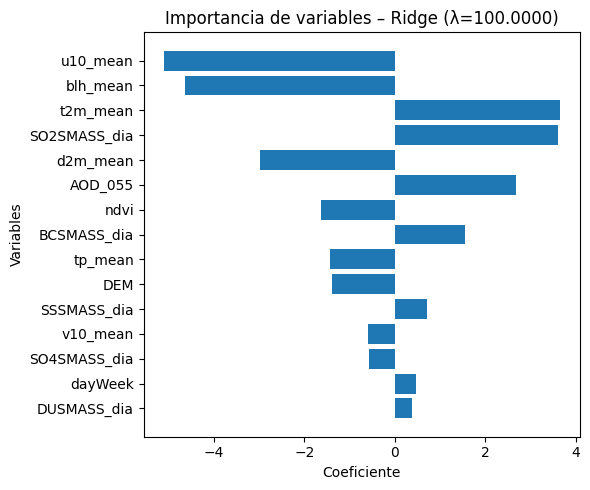

d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


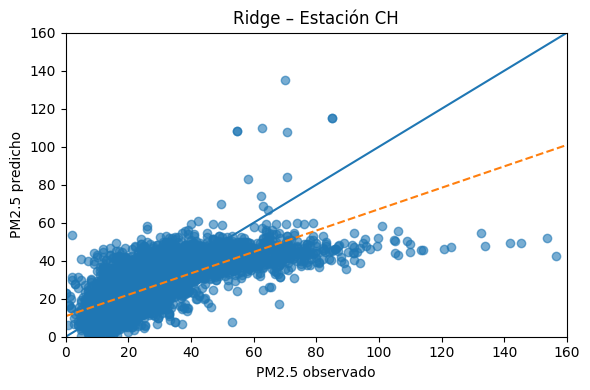

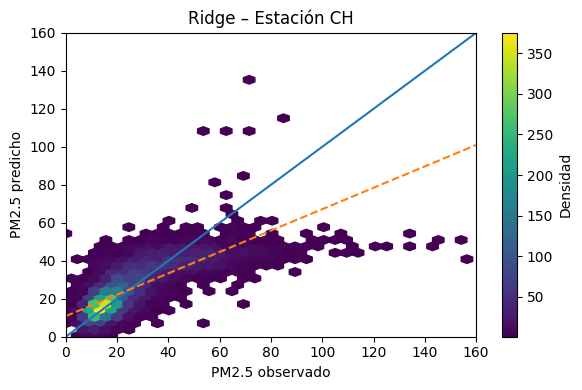

In [ ]:
### -------------- MODELO RIDGE  --------------------------


# Dataset de entrada de entrenamiento y testeo
estacion = "CH"
modelo = "1"

base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/"

train_data = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_test_{estacion}.csv")

## Variables
variables = [
    "AOD_055", "ndvi", "BCSMASS_dia", "DUSMASS_dia",
    "DEM", "t2m_mean",
    "SO2SMASS_dia", "SO4SMASS_dia", "SSSMASS_dia",
    "blh_mean", "d2m_mean", "v10_mean", "u10_mean",
    "tp_mean", "dayWeek"
]

#Generar dataset para ajustar modelos
X_train = train_data[variables]
y_train = train_data["PM25"]

X_test  = test_data[variables]
y_test  = test_data["PM25"]


#Estandarizar variables
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#Setear coeficientes, se hacen distintas pruebas
alphas = np.logspace(-4, 2, 50)   # rango típico de lambdas
#Ridge con cv
ridge_cv = RidgeCV(
    alphas=alphas,
    scoring="neg_mean_squared_error",
    cv=10
)
#Ajustar modelo
ridge_cv.fit(X_train_scaled, y_train)
#labda
best_lambda = ridge_cv.alpha_
print("Mejor lambda Ridge:", best_lambda)

#Ridge sin cv
ridge_model = Ridge(alpha=best_lambda)
ridge_model.fit(X_train_scaled, y_train)


## Resultados de las pruebas de los modelos
resultados = evaluar_modelo_ridge(ridge_model, X_test_scaled, y_test)
print(estacion)
print(resultados)

resultados2 = evaluar_modelo_ridge(ridge_cv, X_test_scaled, y_test)
print(resultados2)

coef_df = pd.DataFrame({
    "variable": variables,
    "coeficiente": ridge_model.coef_
})

coef_df = coef_df.reindex(
    coef_df["coeficiente"].abs().sort_values(ascending=False).index
)

### Plot de los coeficientes
plt.figure(figsize=(6, 5))
plt.barh(coef_df["variable"], coef_df["coeficiente"])
plt.gca().invert_yaxis()

plt.xlabel("Coeficiente")
plt.ylabel("Variables")
plt.title(f"Importancia de variables – Ridge (λ={best_lambda:.4f})")

plt.tight_layout()
plt.show()

############################################
pred = ridge_model.predict(X_test_scaled)

df_plot = pd.DataFrame({
    "PM25": y_test,
    "pred": pred
})

df_plot = df_plot[df_plot["pred"] > 0]


# Regresión auxiliar para línea punteada
lr_aux = LinearRegression()
lr_aux.fit(df_plot[["PM25"]], df_plot["pred"])

x_line = np.linspace(0, 160, 100).reshape(-1, 1)
y_line = lr_aux.predict(x_line)

#####################################################
#plot
plt.figure(figsize=(6, 4))
plt.scatter(df_plot["PM25"], df_plot["pred"], alpha=0.6)

# Línea 1:1
plt.plot([0, 160], [0, 160])

# Línea de regresión
plt.plot(x_line, y_line, linestyle="--")

plt.xlim(0, 160)
plt.ylim(0, 160)

plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"Ridge – Estación {estacion}")

plt.tight_layout()
plt.show()

#####################
#Otro plot
plt.figure(figsize=(6, 4))

hb = plt.hexbin(
    df_plot["PM25"],
    df_plot["pred"],
    gridsize=35,
    mincnt=1
)

plt.colorbar(hb, label="Densidad")

plt.plot([0, 160], [0, 160])
plt.plot(x_line, y_line, linestyle="--")

plt.xlim(0, 160)
plt.ylim(0, 160)

plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"Ridge – Estación {estacion}")

plt.tight_layout()
plt.show()


        R2  Pearson   RMSE   Bias  Min_Pred  Max_Pred
0  0.68188    0.826  9.287 -0.063     0.182    82.462
CH


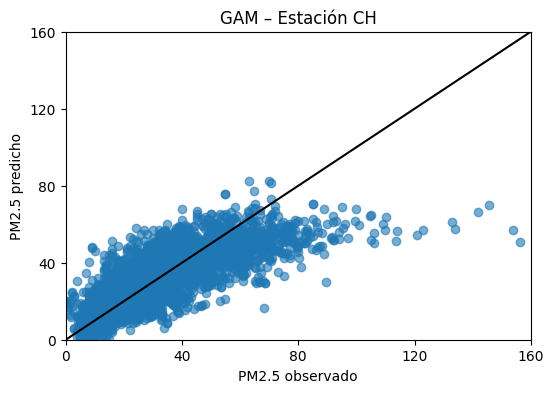

In [6]:
### -------------- Modelo predictivo Modelo Aditivo Generalizado (GAM)  --------------------------

# Dataset de entrada de entrenamiento y testeo
estacion = "CH"
modelo = "1"

base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/"

train_data = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_test_{estacion}.csv")


# # Variables 
vars_numericas = [
    "AOD_055","ndvi","BCSMASS_dia","DUSMASS_dia",
    "SO2SMASS_dia","SO4SMASS_dia","SSSMASS_dia",
    "blh_mean","d2m_mean","t2m_mean",
    "v10_mean","u10_mean","tp_mean","DEM"
]

vars_categoricas = ["dayWeek"]
variables = vars_numericas + vars_categoricas

#Dividir que variables voy a considerar o no
X_train = train_data[variables].values
y_train = train_data["PM25"].values

X_test  = test_data[variables].values
y_test  = test_data["PM25"].values


#COeficientes que voy a usar en cada una ed las varibles seteadas antes
terms = (
    s(0, n_splines=10) +   # AOD_055
    s(1, n_splines=20) +   # ndvi
    s(2, n_splines=10) +   # BCSMASS
    s(3, n_splines=10) +
    s(4, n_splines=10) +
    s(5, n_splines=10) +
    s(6, n_splines=12) +
    s(7, n_splines=10) +
    s(8, n_splines=10) +
    s(9, n_splines=10) +
    s(10, n_splines=10) +
    s(11, n_splines=10) +
    s(12, n_splines=12) +
    s(13, n_splines=5)  +  # DEM
    f(14)                  # dayWeek (factor)
)

#Ajustar modelo
gam_model = LinearGAM(
    terms,
    lam=0.6              # equivalente al control de suavidad
).fit(X_train, y_train)


# Evaluar el desempeño
resultados_gam, df_pred = evaluar_modelo_gam(gam_model, X_test, y_test)
print(resultados_gam)

print(estacion)

#################
#Plot
plt.figure(figsize=(6,4))
plt.scatter(df_pred["PM25"], df_pred["pred"], alpha=0.6)
plt.plot([0,160], [0,160], color="black")

plt.xlim(0,160)
plt.ylim(0,160)
plt.xticks(np.arange(0,161,40))
plt.yticks(np.arange(0,161,40))

plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"GAM – Estación {estacion}")


plt.grid(False)
plt.show()


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PM25       
No. Observations: 15800   Method:             REML       
No. Groups:       2513    Scale:              45.7313    
Min. group size:  1       Log-Likelihood:     -56790.9033
Max. group size:  11      Converged:          Yes        
Mean group size:  6.3                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      21.712    0.380 57.185 0.000 20.968 22.457
AOD_055        21.592    1.926 11.210 0.000 17.816 25.367
Group Var     209.379    0.994                           

{'R2': np.float64(0.012), 'RMSE': np.float64(16.368), 'Bias': np.float64(-0.29), 'Min': np.float64(21.72), 'Max': np.float64(43.59)}


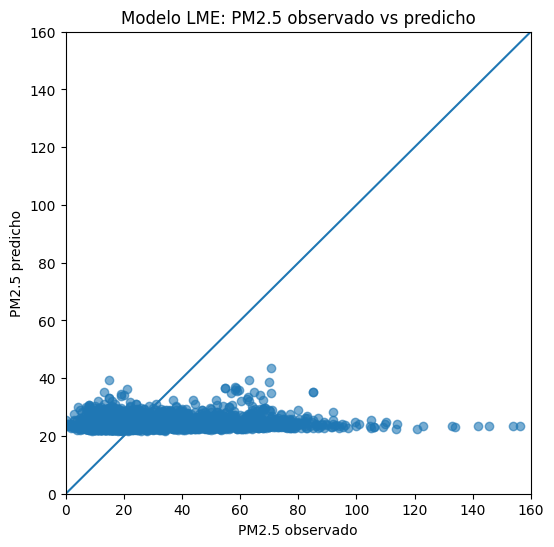

In [ ]:
### -------------- Modelo predictivo Modelo Lineal Mixto (LME)   --------------------------
#Varios puntos  atener en cuenta en este tipo de modelo:
#  - random effects mal definidos
#  - Un random effect solo puede ser una variable categórica
#  - Random slopes mal controlados → explosión de predicciones
#  - Escalado: posible data leakage (grave)

# Dataset de entrada de entrenamiento y testeo
estacion = "CH"
modelo = "1"

base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/"

train_data = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_test_{estacion}.csv")

# Factores (equivalente a as.factor)
train_data["fecha"] = train_data["date"].astype("category")
test_data["fecha"]  = test_data["date"].astype("category")

train_data["estacion"] = train_data["estacion"].astype("category")
test_data["estacion"]  = test_data["estacion"].astype("category")

#Ajustar modelo
modelo_lme = smf.mixedlm(
    "PM25 ~ AOD_055",
    train_data,
    # groups=train_data["estacion"]
    groups=train_data["fecha"]
)

modelo_lme_fit = modelo_lme.fit(reml=True)
print(modelo_lme_fit.summary())

#Prediccion
test_data["pred"] = modelo_lme_fit.predict(test_data)
## Funcion para evaluar el modelo
def evaluar_modelo_lme(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2 = np.corrcoef(y_true, y_pred)[0,1]**2
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)

    return {
        "R2": round(r2, 3),
        "RMSE": round(rmse, 3),
        "Bias": round(bias, 3),
        "Min": round(y_pred.min(), 2),
        "Max": round(y_pred.max(), 2)
    }

resultados_lme = evaluar_modelo_lme(
    test_data["PM25"].values,
    test_data["pred"].values
)

print(resultados_lme)

#########Plot
plt.figure(figsize=(6,6))
plt.scatter(test_data["PM25"], test_data["pred"], alpha=0.6)
plt.plot([0,160], [0,160])
plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title("Modelo LME: PM2.5 observado vs predicho")
plt.show()

#Revisar

GLM Gaussian:
CH
{'R2': np.float64(0.569), 'RMSE': np.float64(10.82), 'Bias': np.float64(0.093), 'Min': np.float64(0.13), 'Max': np.float64(134.88)}


d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM Gaussian log:
{'R2': np.float64(0.626), 'RMSE': np.float64(10.07), 'Bias': np.float64(-0.132), 'Min': np.float64(0.98), 'Max': np.float64(127.12)}
GLM Gamma log:
{'R2': np.float64(0.085), 'RMSE': np.float64(42.31), 'Bias': np.float64(1.079), 'Min': np.float64(3.93), 'Max': np.float64(2631.68)}


d:\Josefina\Proyectos\Tesis\code\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM Inverse Gaussian:
{'R2': np.float64(0.004), 'RMSE': np.float64(2651.663), 'Bias': np.float64(55.013), 'Min': np.float64(5.65), 'Max': np.float64(205712.65)}


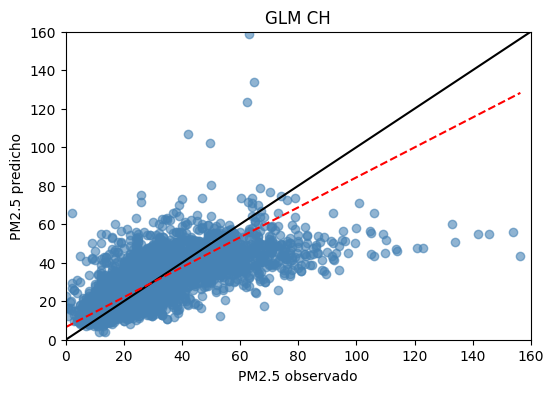

In [23]:
## ### ----- Modelo predictivo Modelo Lineal Generalizado (GLM)   ----- 


# Dataset de entrada de entrenamiento y testeo
estacion = "CH"
modelo = "1"

base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/"

train_data = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{base_dir}/Modelo_{modelo}/M{modelo}_test_{estacion}.csv")

# Quitar valores no positivos (igual que en R)
train_data = train_data[train_data["PM25"] > 0]
test_data  = test_data[test_data["PM25"] > 0]

#Variables va a depender de cada centro urbnano
formula = """
PM25 ~ AOD_055 + ndvi + BCSMASS_dia + DUSMASS_dia + DEM + t2m_mean +
        SO2SMASS_dia + SO4SMASS_dia + SSSMASS_dia + blh_mean +
        d2m_mean + v10_mean + u10_mean + tp_mean + dayWeek
"""
########################################################
# Se hacen distintas pruebas de los modelos cambiando los links, la relacion, la funcion
# Generar el modelo/ Ajustar modelo
glm_gaussian = smf.glm(
    formula=formula,
    data=train_data,
    family=sm.families.Gaussian()
).fit()

#Genear predicciones para evaluarlo con el set de testeo
pred_gaussian = glm_gaussian.predict(test_data)

#Evaluar el desempeño, mostrar los resultados
print("GLM Gaussian:")
print(estacion)
print(evaluar_modelo_glm(test_data["PM25"].values, pred_gaussian))


####---- Otra prueba del modelo
glm_gaussian_log = smf.glm(
    formula=formula,
    data=train_data,
    family=sm.families.Gaussian(sm.families.links.log())
).fit()

pred_gaussian_log = glm_gaussian_log.predict(test_data)

print("GLM Gaussian log:")
print(evaluar_modelo_glm(test_data["PM25"].values, pred_gaussian_log))

####---- Otra prueba del modelo
glm_gamma_log = smf.glm(
    formula=formula,
    data=train_data,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

pred_gamma = glm_gamma_log.predict(test_data)

print("GLM Gamma log:")
print(evaluar_modelo_glm(test_data["PM25"].values, pred_gamma))

####---- Otra prueba del modelo
glm_ig = smf.glm(
    formula=formula,
    data=train_data,
    family=sm.families.InverseGaussian(sm.families.links.log())
).fit()

pred_ig = glm_ig.predict(test_data)

print("GLM Inverse Gaussian:")
print(evaluar_modelo_glm(test_data["PM25"].values, pred_ig))




########################################################################
#Plot considerando el ultimo modelo (no el mejor, sino se va cambiando)
test_data["pred"] = pred_gamma
test_data = test_data[test_data["pred"] > 0]
plt.figure(figsize=(6,4))
plt.scatter(test_data["PM25"], test_data["pred"], alpha=0.6, color="steelblue")
plt.plot([0,160], [0,160], color="black")
plt.plot(
    np.unique(test_data["PM25"]),
    np.poly1d(np.polyfit(test_data["PM25"], test_data["pred"], 1))(np.unique(test_data["PM25"])),
    color="red",
    linestyle="--"
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("PM2.5 observado")
plt.ylabel("PM2.5 predicho")
plt.title(f"GLM {estacion}")
plt.show()


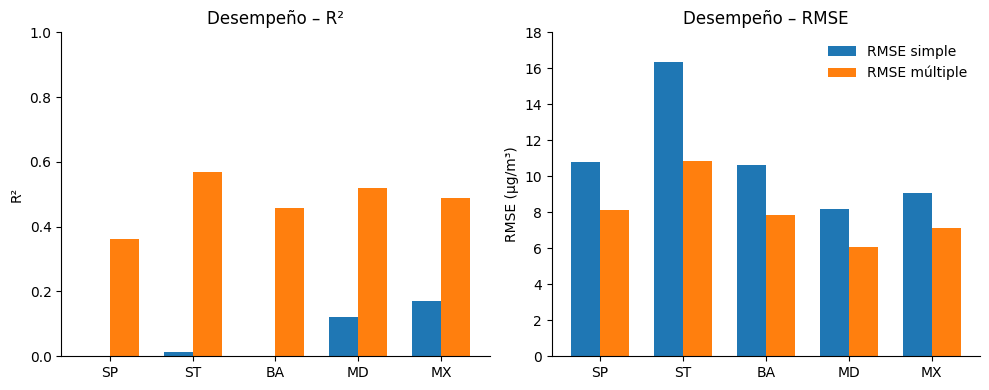

In [27]:
# Comparativa de las metricas obtenidas para cada uno de los centros urbanos/modelos de RLS-RLM
#S hizo manualmente
# ======================
# Datos

data = pd.DataFrame({
    "Centro": ["SP", "ST", "BA", "MD", "MX"],
    "R2_simple": [2.00e-05, 0.01223, 0.00012, 0.12, 0.16922],
    "R2_multiple": [0.3611, 0.56837, 0.45914, 0.52, 0.48979],
    "RMSE_simple": [10.82, 16.368, 10.636, 8.20, 9.068],
    "RMSE_multiple": [8.121, 10.823, 7.847, 6.06, 7.104]
})

# Orden deseado de los centros urbanos
data["Centro"] = pd.Categorical(
    data["Centro"], categories=["SP", "ST", "BA", "MD", "MX"], ordered=True
)
data = data.sort_values("Centro")

x = np.arange(len(data))
width = 0.35
###############################
# Figura 1 fila x 2 columnas

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
# ----------------------
# subplot 1: R2

axes[0].bar(x - width/2, data["R2_simple"], width, label="R² simple")
axes[0].bar(x + width/2, data["R2_multiple"], width, label="R² múltiple")

axes[0].set_ylabel("R²")
axes[0].set_ylim(0, 1)
axes[0].set_title("Desempeño – R²")

# ----------------------
# subplot 2: RMSE
axes[1].bar(x - width/2, data["RMSE_simple"], width, label="RMSE simple")
axes[1].bar(x + width/2, data["RMSE_multiple"], width, label="RMSE múltiple")

axes[1].set_ylabel("RMSE (µg/m³)")
axes[1].set_ylim(0, 18)
axes[1].set_title("Desempeño – RMSE")

# ----------------------
# Ejes y estilo

for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(data["Centro"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Leyenda 
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()


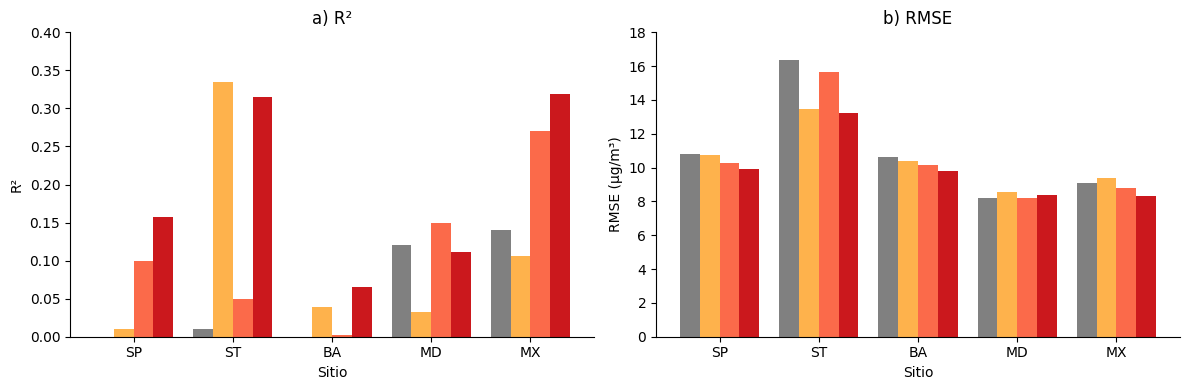

In [ ]:
#Comparativa entre los modelos con correcciones en el AOD de RLS
# ======================
# Datos

data = pd.DataFrame({
    "Centro": ["SP", "ST", "BA", "MD", "MX"],

    "R2_RLS": [2.00e-05, 0.01, 0.0001, 0.12, 0.14],
    "R2_BLH": [0.01062, 0.33424, 0.03947, 0.03289, 0.106],
    "R2_RH": [0.10, 0.05, 0.002, 0.15, 0.27],
    "R2_RH_BLH": [0.15691, 0.31548, 0.065, 0.11149, 0.31876],

    "RMSE_RLS": [10.82, 16.37, 10.64, 8.20, 9.07],
    "RMSE_BLH": [10.76, 13.44, 10.417, 8.57, 9.412],
    "RMSE_RH": [10.288, 15.643, 10.15, 8.18, 8.816],
    "RMSE_RH_BLH": [9.94, 13.239, 9.796, 8.377, 8.329]
})

# Orden de sitios
data["Centro"] = pd.Categorical(
    data["Centro"], categories=["SP", "ST", "BA", "MD", "MX"], ordered=True
)
data = data.sort_values("Centro")

# ======================
# Parametros comunes

x = np.arange(len(data))
width = 0.2

colors = {
    "RLS": "grey",
    "BLH": "#feb24c",
    "RH": "#fb6a4a",
    "RH+BLH": "#cb181d"
}

# ======================
# Figura con subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# ==========================================================
# SUBPLOT 1 — R²

ax = axes[0]

ax.bar(x - 1.5*width, data["R2_RLS"], width, color=colors["RLS"])
ax.bar(x - 0.5*width, data["R2_BLH"], width, color=colors["BLH"])
ax.bar(x + 0.5*width, data["R2_RH"], width, color=colors["RH"])
ax.bar(x + 1.5*width, data["R2_RH_BLH"], width, color=colors["RH+BLH"])

ax.set_ylabel("R²")
ax.set_ylim(0, 0.4)
ax.set_title("R²")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ==========================================================
# SUBPLOT 2 — RMSE

ax = axes[1]

ax.bar(x - 1.5*width, data["RMSE_RLS"], width, color=colors["RLS"])
ax.bar(x - 0.5*width, data["RMSE_BLH"], width, color=colors["BLH"])
ax.bar(x + 0.5*width, data["RMSE_RH"], width, color=colors["RH"])
ax.bar(x + 1.5*width, data["RMSE_RH_BLH"], width, color=colors["RH+BLH"])

ax.set_ylabel("RMSE (µg/m³)")
ax.set_ylim(0, 18)
ax.set_title("b) RMSE")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ======================
# Eje X compartido

for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(data["Centro"])
    ax.set_xlabel("Sitio")

plt.tight_layout()
plt.show()
